In [1]:
        !pip install pandas



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Caminho do arquivo CSV
file_path = "/Users/eduardosiqueirabonfim/Documents/Unicamp/Embarcados/ES670-2024-GrupoA2/jupyterNotebookForPlottingData/dutyCycle07_TrainingData.csv"

# Carregar os dados do arquivo CSV, ignorando a primeira linha
data = pd.read_csv(file_path, sep="\t", skiprows=1, header=None)

# Exibir as primeiras linhas do dataframe para entender sua estrutura
print(data.head())

# Dividir a coluna única em duas colunas 'X' e 'Y'
data[['Segundos', 'Temperatura em graus']] = data[0].str.split(',', expand=True)

# Remover a coluna original que foi dividida
data = data.drop(columns=[0])

# Remover os espaços em branco ao redor dos valores das colunas
data['Segundos'] = data['Segundos'].str.strip()
data['Temperatura em graus'] = data['Temperatura em graus'].str.strip()

# Converter as colunas para tipo numérico
data['Segundos'] = pd.to_numeric(data['Segundos'].str.replace('X: ', ''))
data['Temperatura em graus'] = pd.to_numeric(data['Temperatura em graus'].str.replace('Y: ', ''))

# Exibir as primeiras linhas do dataframe processado para verificação
print(data.head())

                  0
0  X: 0.2, Y: 32.46
1  X: 0.3, Y: 32.38
2  X: 0.4, Y: 32.38
3  X: 0.5, Y: 32.30
4  X: 0.6, Y: 32.30
   Segundos  Temperatura em graus
0       0.2                 32.46
1       0.3                 32.38
2       0.4                 32.38
3       0.5                 32.30
4       0.6                 32.30


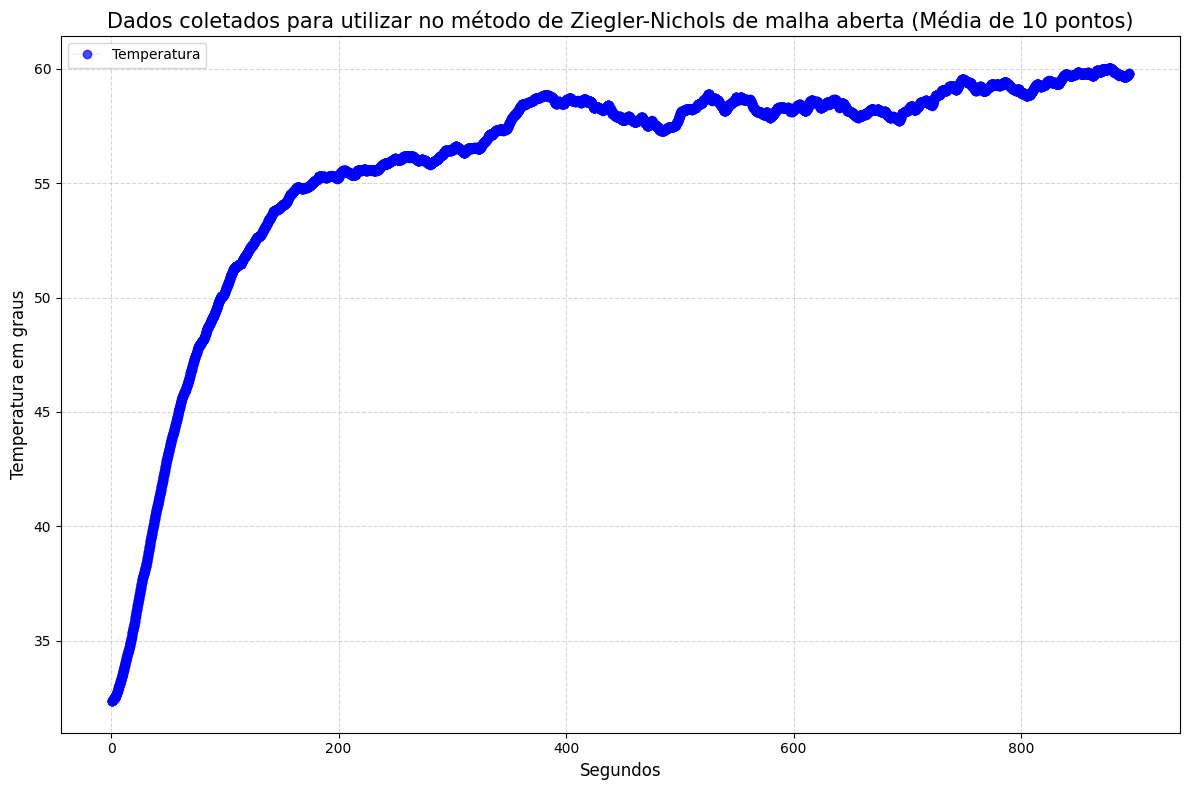

In [3]:
# Calcular a média móvel com um tamanho de janela de 10 pontos (suavizar os dados e identificar tendências gerais, removendo flutuações aleatórias de curto prazo)
data_rolled = data.rolling(window=10).mean().dropna()

plt.figure(figsize=(12, 8))
plt.plot(data_rolled['Segundos'], data_rolled['Temperatura em graus'], marker='o', linestyle='-', linewidth=0.1, color='b', alpha=0.7, label='Temperatura')
plt.title('Dados coletados para utilizar no método de Ziegler-Nichols de malha aberta (Média de 10 pontos)', fontsize=15)
plt.xlabel('Segundos', fontsize=12)
plt.ylabel('Temperatura em graus', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

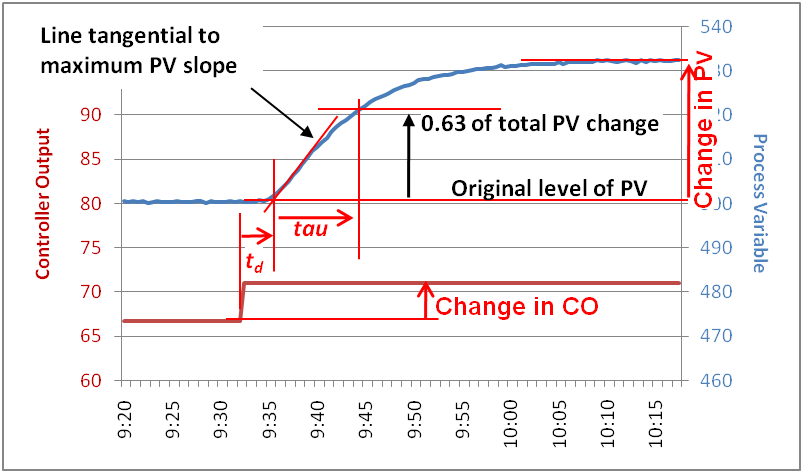

In [4]:
from IPython.display import Image, display
display(Image(filename="/Users/eduardosiqueirabonfim/Documents/Unicamp/Embarcados/ES670-2024-GrupoA2/jupyterNotebookForPlottingData/ZieglerNichols.png"))


Ganho de Processo (Gp): 0.5351059085841694
Tempo de Retardo (t_d): 6.25 segundos
Constante de Tempo (tau): 87.4 segundos
Controlador P: Kc = 26.13314444050918
Controlador PI: Kc = 23.519829996458267, Ti = 20.8125
Controlador PID: Kc = 31.35977332861102, Ti = 12.5, Td = 3.125
Controlador PID Parallel Form: Kp = 31.35977332861102
Controlador PID Parallel Form: Ki = 2.5087818662888814
Controlador PID Parallel Form: Kd = 97.99929165190943


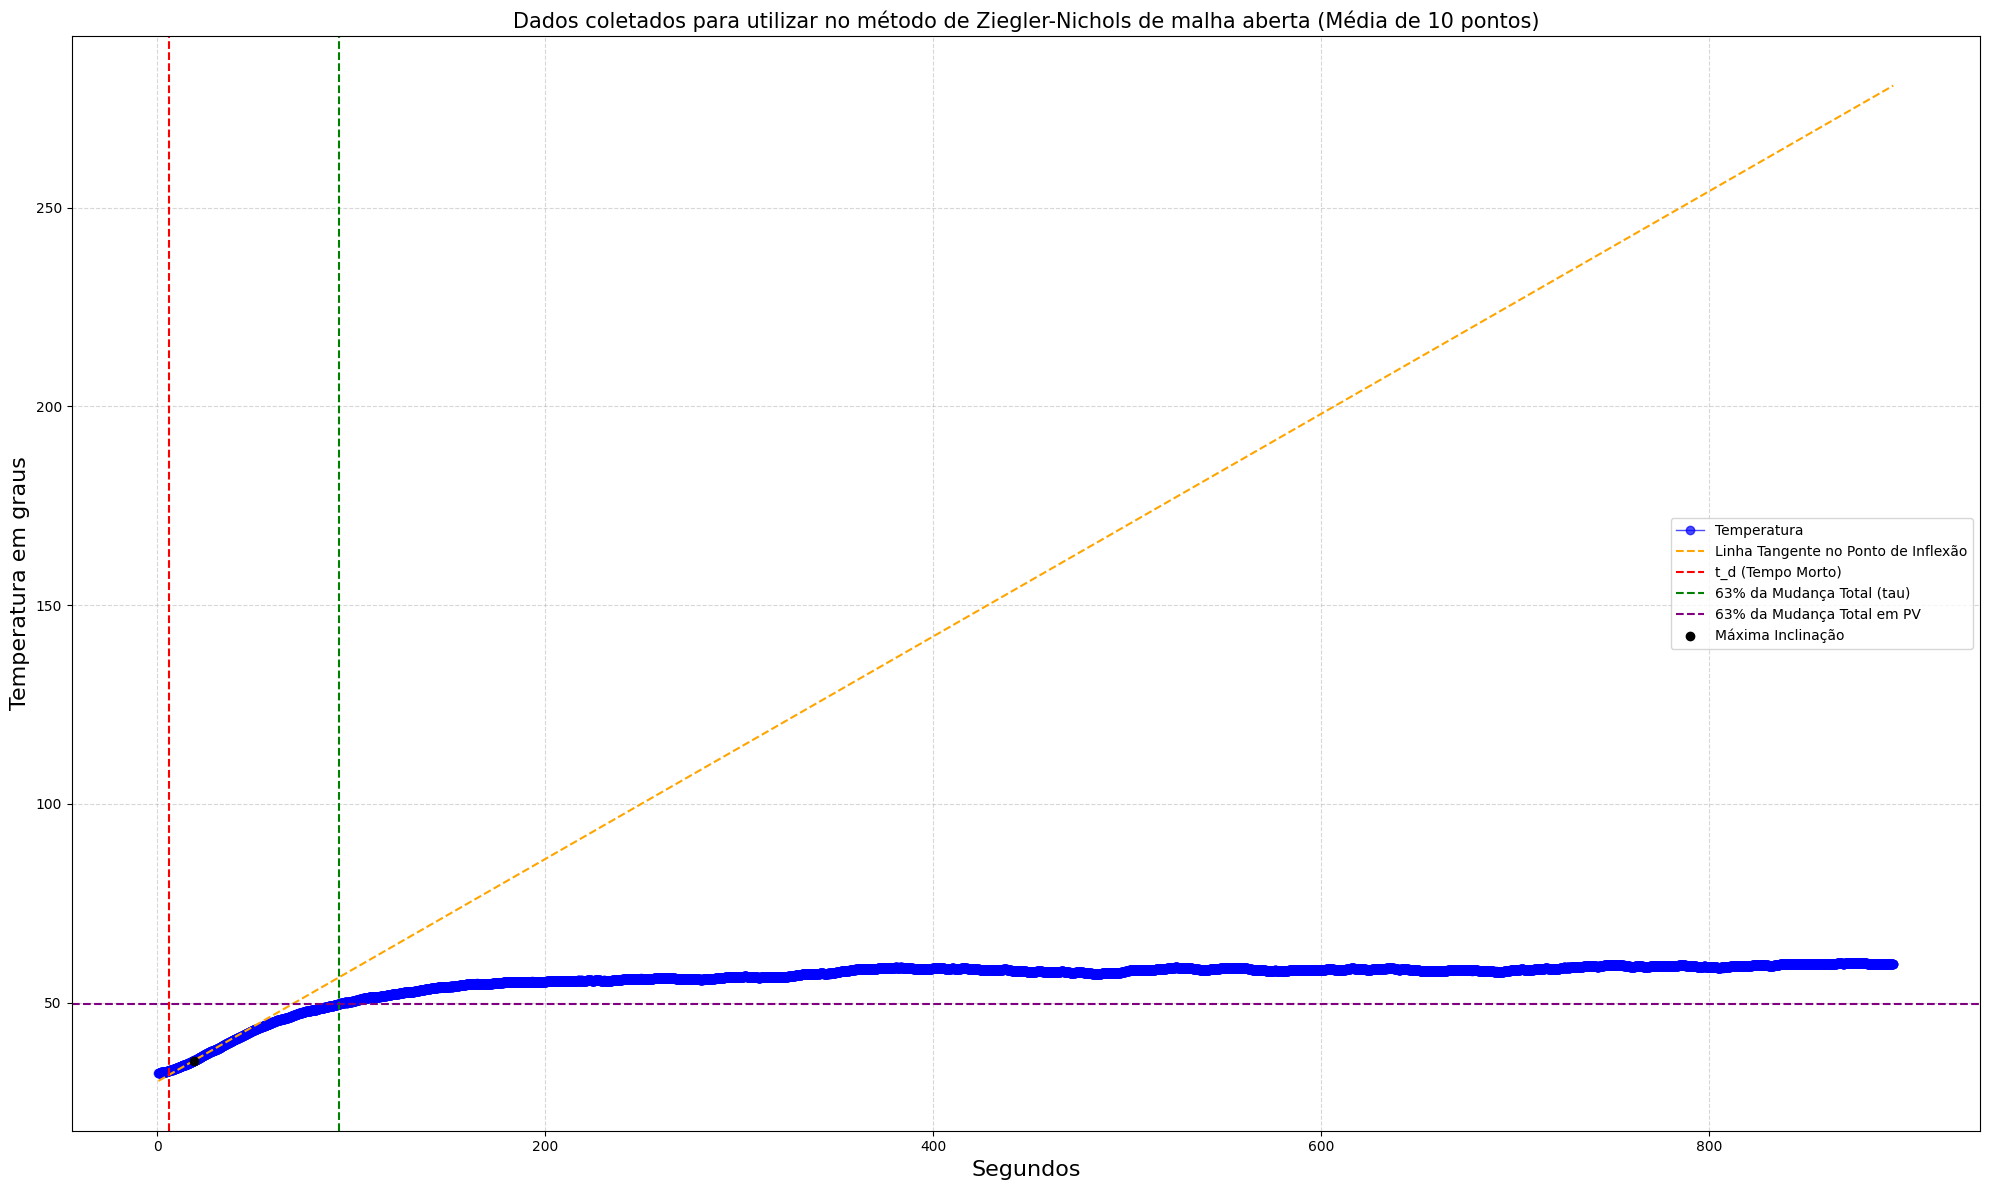

In [5]:
#PV = Process Variable (Variável de Processo)
#CO = Control Output (Saída de Controle)

# Supondo que data_rolled já está carregado com os dados de 'Segundos' e 'Temperatura em graus'
# Identificação do Nível Inicial de PV (Temperatura Inicial)
initial_temp = data_rolled['Temperatura em graus'].iloc[0]

# Determinação do Valor Final de PV (Temperatura Final)
final_temp = data_rolled['Temperatura em graus'].iloc[-1]

# Cálculo da Mudança Total em PV
delta_PV = final_temp - initial_temp

# Determinação de 63% da Mudança Total em PV
PV_63_percent = initial_temp + 0.63 * delta_PV

# Cálculo da derivada primeira para encontrar a máxima inclinação
data_rolled['Derivada'] = np.gradient(data_rolled['Temperatura em graus'], data_rolled['Segundos'])

# Encontrar o tempo com a máxima inclinação (ponto de inflexão)
max_slope_index = data_rolled['Derivada'].idxmax()
max_slope_time = data_rolled['Segundos'].iloc[max_slope_index]
max_slope_temp = data_rolled['Temperatura em graus'].iloc[max_slope_index]
max_slope = data_rolled['Derivada'].iloc[max_slope_index]

# Desenhar a linha tangente
tangent_intercept = max_slope_temp - max_slope * max_slope_time
tangent_line = max_slope * data_rolled['Segundos'] + tangent_intercept

# Identificar o tempo de interseção da linha tangente com o nível inicial de PV (Tempo morto)
intersection_indices = np.where(np.isclose(tangent_line, initial_temp, atol=0.5))[0]
if len(intersection_indices) > 0:
    intersection_index = intersection_indices[0]
    t_d = data_rolled['Segundos'].iloc[intersection_index]
else:
    t_d = np.nan
    print("Interseção não encontrada.")

# Identificação do Tempo de τ (onde o valor de PV é 63% da mudança total)
for i in range(1, len(data_rolled)):
    if data_rolled['Temperatura em graus'].iloc[i] >= PV_63_percent:
        tau_time = data_rolled['Segundos'].iloc[i]
        break

# Cálculo de τ
tau = tau_time - t_d

# Mudança na entrada (CO)
initial_CO = 0.1  # Valor inicial da entrada (duty cycle do heather) - Esperei estabilizar com 10% de duty cycle do heather
final_CO = 0.7   # Valor final da entrada (duty cycle do heather)
delta_CO = final_CO - initial_CO

# Convertendo as mudanças em porcentagem em relação ao valor final
delta_PV_percent = (delta_PV / final_temp) * 100
delta_CO_percent = (delta_CO / final_CO) * 100

# Cálculo do Ganho de Processo (Gp) em termos de % da faixa do dispositivo de medição
Gp = delta_PV_percent / delta_CO_percent

# Verificar se t_d é zero ou NaN e ajustar para um valor razoável se necessário
if np.isnan(t_d) or t_d == 0:
    t_d = 5  # Ajuste para um valor apropriado baseado nos dados reais

# Cálculo dos valores para P, PI e PID controladores usando Ziegler-Nichols
Kc_P = tau / (Gp * t_d)

Kc_PI = 0.9 * tau / (Gp * t_d)
Ti_PI = 3.33 * t_d

Kc_PID = (1.2 * tau / (Gp * t_d))
Ti_PID = 2 * t_d
Td_PID = 0.5 * t_d

# Converting the interactive form parameters to the parallel form
Kc = Kc_PID
Ki = Kc_PID / Ti_PID
Kd = Kc_PID * Td_PID

# Exibição dos resultados
print(f"Ganho de Processo (Gp): {Gp}")
print(f"Tempo de Retardo (t_d): {t_d} segundos")
print(f"Constante de Tempo (tau): {tau} segundos")

print(f"Controlador P: Kc = {Kc_P}")
print(f"Controlador PI: Kc = {Kc_PI}, Ti = {Ti_PI}")
print(f"Controlador PID: Kc = {Kc_PID}, Ti = {Ti_PID}, Td = {Td_PID}")

print(f"Controlador PID Parallel Form: Kp = {Kc}")
print(f"Controlador PID Parallel Form: Ki = {Ki}")
print(f"Controlador PID Parallel Form: Kd = {Kd}")

# Plot the data with annotations
plt.figure(figsize=(20, 12))
plt.plot(data_rolled['Segundos'], data_rolled['Temperatura em graus'], marker='o', linestyle='-', linewidth=1, color='b', alpha=0.7, label='Temperatura')
plt.plot(data_rolled['Segundos'], tangent_line, linestyle='--', color='orange', label='Linha Tangente no Ponto de Inflexão')
plt.axvline(x=t_d, color='r', linestyle='--', label='t_d (Tempo Morto)')
plt.axvline(x=tau_time, color='g', linestyle='--', label='63% da Mudança Total (tau)')
plt.axhline(y=PV_63_percent, color='purple', linestyle='--', label='63% da Mudança Total em PV')
plt.scatter(max_slope_time, max_slope_temp, color='black', label='Máxima Inclinação', zorder=5)
plt.title('Dados coletados para utilizar no método de Ziegler-Nichols de malha aberta (Média de 10 pontos)', fontsize=15)
plt.xlabel('Segundos', fontsize=16)
plt.ylabel('Temperatura em graus', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
#Apos conversar com  o professor resolvi rodar novamente os testes


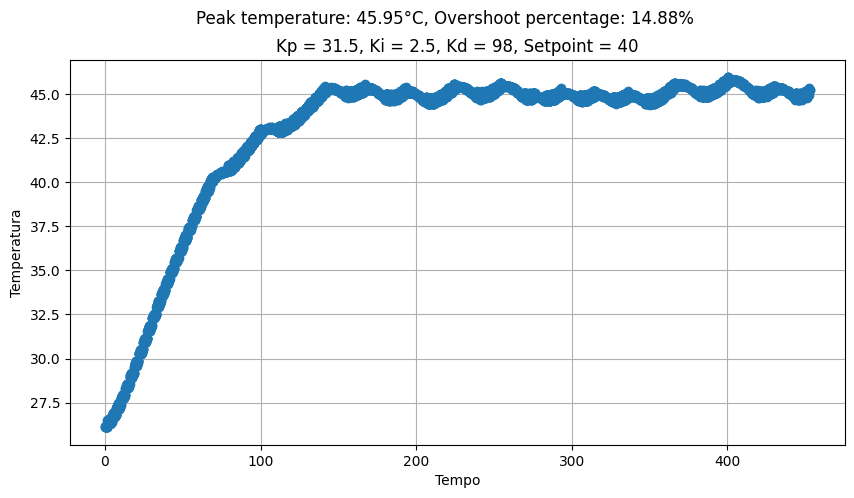

In [7]:
file_path = '/Users/eduardosiqueirabonfim/Documents/Unicamp/Embarcados/ES670-2024-GrupoA2/jupyterNotebookForPlottingData/07-06 Data/31.5-2.5-98-40.csv'

# Le o arquivo e pula linhas irregulares
data = []
with open(file_path, 'r') as file:
    for line in file:
        if 't:' in line and 'T:' in line:
            parts = line.split(',')
            t_value = float(parts[0].split(':')[1].strip())
            T_value = float(parts[1].split(':')[1].strip())
            data.append((t_value, T_value))

# Converta a lista de tuplas em um DataFrame
df = pd.DataFrame(data, columns=['Time', 'Temperature'])

#Overshoot

# Achar a temperatura maxima
peak_temperature = df['Temperature'].max()

# Setpoint
steady_state_temp = 40

# Calculate the overshoot percentage
if steady_state_temp != 0:  # Avoid division by zero
    overshoot_percentage = ((peak_temperature - steady_state_temp) / steady_state_temp) * 100
else:
    overshoot_percentage = float('nan')  # Set overshoot to NaN if steady-state is zero
    
# Plotting Time versus Temperature 
plt.figure(figsize=(10, 5))
plt.plot(df['Time'], df['Temperature'], marker='o', linestyle='-', linewidth=0.5)
plt.xlabel('Tempo')
plt.ylabel('Temperatura')
plt.title('Kp = 31.5, Ki = 2.5, Kd = 98, Setpoint = 40')
plt.suptitle(f"Peak temperature: {peak_temperature}°C, " f"Overshoot percentage: {overshoot_percentage:.2f}%")
plt.grid(True)
plt.show()


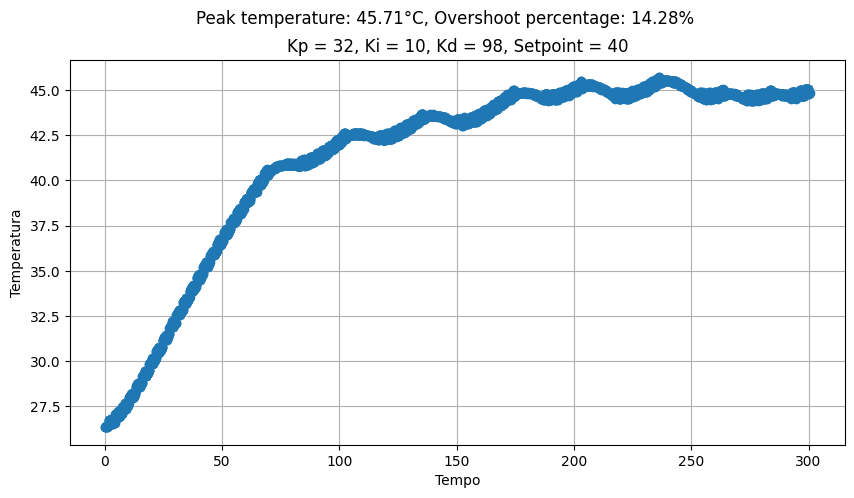

In [8]:
#32-10-98-40
#Aumentando Ki porque o erro estacionario estava alto

file_path = '/Users/eduardosiqueirabonfim/Documents/Unicamp/Embarcados/ES670-2024-GrupoA2/jupyterNotebookForPlottingData/07-06 Data/32-10-98-40.csv'

# Le o arquivo e pula linhas irregulares
data = []
with open(file_path, 'r') as file:
    for line in file:
        if 't:' in line and 'T:' in line:
            parts = line.split(',')
            t_value = float(parts[0].split(':')[1].strip())
            T_value = float(parts[1].split(':')[1].strip())
            data.append((t_value, T_value))

# Converta a lista de tuplas em um DataFrame
df = pd.DataFrame(data, columns=['Time', 'Temperature'])

#Overshoot

# Achar a temperatura maxima
peak_temperature = df['Temperature'].max()

# Setpoint
steady_state_temp = 40

# Calculate the overshoot percentage
if steady_state_temp != 0:  # Avoid division by zero
    overshoot_percentage = ((peak_temperature - steady_state_temp) / steady_state_temp) * 100
else:
    overshoot_percentage = float('nan')  # Set overshoot to NaN if steady-state is zero
    
# Plotting Time versus Temperature 
plt.figure(figsize=(10, 5))
plt.plot(df['Time'], df['Temperature'], marker='o', linestyle='-', linewidth=0.5)
plt.xlabel('Tempo')
plt.ylabel('Temperatura')
plt.title('Kp = 32, Ki = 10, Kd = 98, Setpoint = 40')
plt.suptitle(f"Peak temperature: {peak_temperature}°C, " f"Overshoot percentage: {overshoot_percentage:.2f}%")
plt.grid(True)
plt.show()

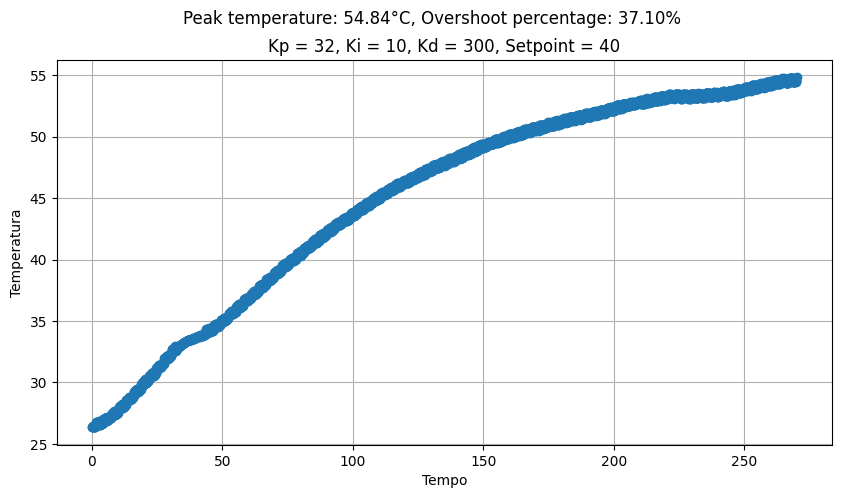

In [9]:
#32-10-300-40
#Aumentando Kd porque o overshoot estava alto

file_path = '/Users/eduardosiqueirabonfim/Documents/Unicamp/Embarcados/ES670-2024-GrupoA2/jupyterNotebookForPlottingData/07-06 Data/32-10-300-40.csv'

# Le o arquivo e pula linhas irregulares
data = []
with open(file_path, 'r') as file:
    for line in file:
        if 't:' in line and 'T:' in line:
            parts = line.split(',')
            t_value = float(parts[0].split(':')[1].strip())
            T_value = float(parts[1].split(':')[1].strip())
            data.append((t_value, T_value))

# Converta a lista de tuplas em um DataFrame
df = pd.DataFrame(data, columns=['Time', 'Temperature'])

#Overshoot

# Achar a temperatura maxima
peak_temperature = df['Temperature'].max()

# Setpoint
steady_state_temp = 40

# Calculate the overshoot percentage
if steady_state_temp != 0:  # Avoid division by zero
    overshoot_percentage = ((peak_temperature - steady_state_temp) / steady_state_temp) * 100
else:
    overshoot_percentage = float('nan')  # Set overshoot to NaN if steady-state is zero
    
# Plotting Time versus Temperature 
plt.figure(figsize=(10, 5))
plt.plot(df['Time'], df['Temperature'], marker='o', linestyle='-', linewidth=0.5)
plt.xlabel('Tempo')
plt.ylabel('Temperatura')
plt.title('Kp = 32, Ki = 10, Kd = 300, Setpoint = 40')
plt.suptitle(f"Peak temperature: {peak_temperature}°C, " f"Overshoot percentage: {overshoot_percentage:.2f}%")
plt.grid(True)
plt.show()

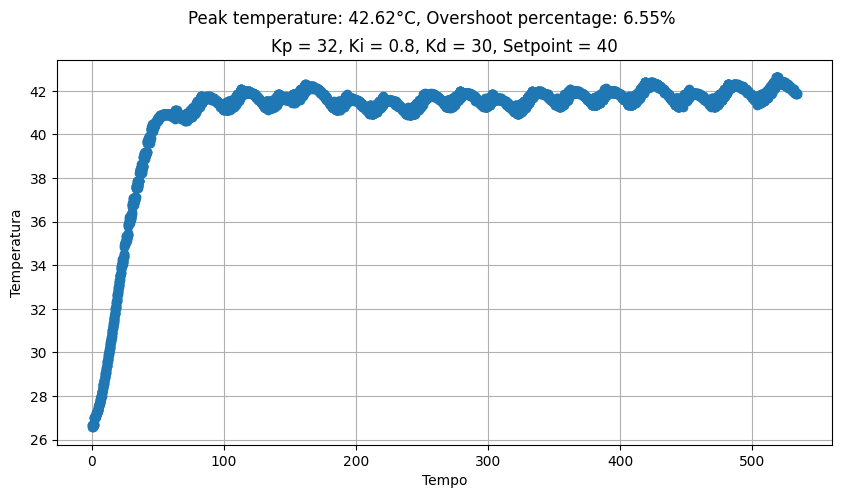

In [10]:
#32-0.8-30-40
#Diminuindo Ki e Kd porque o overshoot estava alto e o erro estacionario tambem

file_path = '/Users/eduardosiqueirabonfim/Documents/Unicamp/Embarcados/ES670-2024-GrupoA2/jupyterNotebookForPlottingData/07-06 Data/32-0.8-30-40.csv'

# Le o arquivo e pula linhas irregulares
data = []
with open(file_path, 'r') as file:
    for line in file:
        if 't:' in line and 'T:' in line:
            parts = line.split(',')
            t_value = float(parts[0].split(':')[1].strip())
            T_value = float(parts[1].split(':')[1].strip())
            data.append((t_value, T_value))

# Converta a lista de tuplas em um DataFrame
df = pd.DataFrame(data, columns=['Time', 'Temperature'])

#Overshoot

# Achar a temperatura maxima
peak_temperature = df['Temperature'].max()

# Setpoint
steady_state_temp = 40

# Calculate the overshoot percentage
if steady_state_temp != 0:  # Avoid division by zero
    overshoot_percentage = ((peak_temperature - steady_state_temp) / steady_state_temp) * 100
else:
    overshoot_percentage = float('nan')  # Set overshoot to NaN if steady-state is zero
    
# Plotting Time versus Temperature 
plt.figure(figsize=(10, 5))
plt.plot(df['Time'], df['Temperature'], marker='o', linestyle='-', linewidth=0.5)
plt.xlabel('Tempo')
plt.ylabel('Temperatura')
plt.title('Kp = 32, Ki = 0.8, Kd = 30, Setpoint = 40')
plt.suptitle(f"Peak temperature: {peak_temperature}°C, " f"Overshoot percentage: {overshoot_percentage:.2f}%")
plt.grid(True)
plt.show()

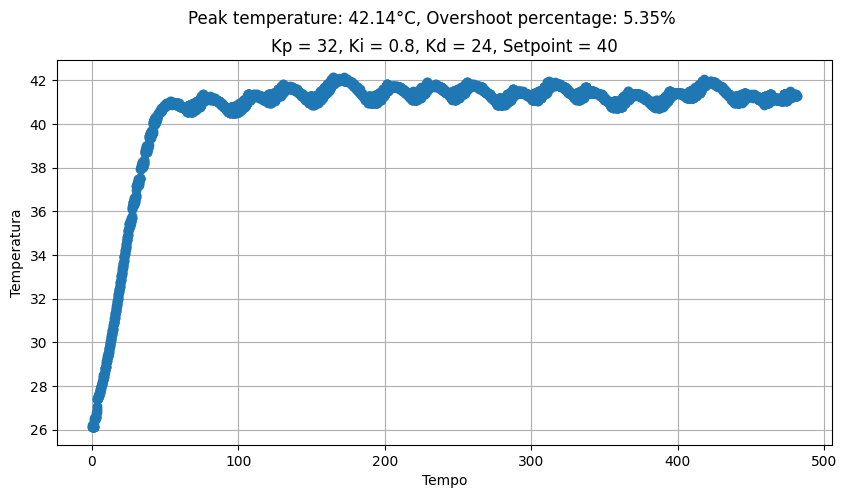

In [11]:
!#32-0.8-24-40
#Diminuindo o Kd pra tentar diminuir o overshoot

file_path = '/Users/eduardosiqueirabonfim/Documents/Unicamp/Embarcados/ES670-2024-GrupoA2/jupyterNotebookForPlottingData/07-06 Data/32-0.8-24-40.csv'

# Le o arquivo e pula linhas irregulares
data = []
with open(file_path, 'r') as file:
    for line in file:
        if 't:' in line and 'T:' in line:
            parts = line.split(',')
            t_value = float(parts[0].split(':')[1].strip())
            T_value = float(parts[1].split(':')[1].strip())
            data.append((t_value, T_value))

# Converta a lista de tuplas em um DataFrame
df = pd.DataFrame(data, columns=['Time', 'Temperature'])

#Overshoot

# Achar a temperatura maxima
peak_temperature = df['Temperature'].max()

# Setpoint
steady_state_temp = 40

# Calculate the overshoot percentage
if steady_state_temp != 0:  # Avoid division by zero
    overshoot_percentage = ((peak_temperature - steady_state_temp) / steady_state_temp) * 100
else:
    overshoot_percentage = float('nan')  # Set overshoot to NaN if steady-state is zero
    
# Plotting Time versus Temperature 
plt.figure(figsize=(10, 5))
plt.plot(df['Time'], df['Temperature'], marker='o', linestyle='-', linewidth=0.5)
plt.xlabel('Tempo')
plt.ylabel('Temperatura')
plt.title('Kp = 32, Ki = 0.8, Kd = 24, Setpoint = 40')
plt.suptitle(f"Peak temperature: {peak_temperature}°C, " f"Overshoot percentage: {overshoot_percentage:.2f}%")
plt.grid(True)
plt.show()

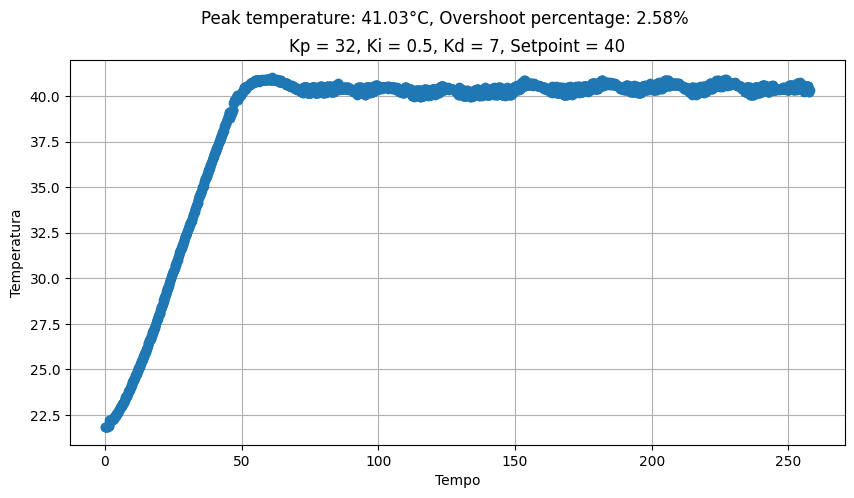

In [12]:
#Diminuindo o Kd pra tentar diminuir o overshoot
#Diminuindo o Ki pra tentar diminuir o erro estacionario

file_path = '/Users/eduardosiqueirabonfim/Documents/Unicamp/Embarcados/ES670-2024-GrupoA2/jupyterNotebookForPlottingData/07-06 Data/32-0.5-7-40.csv'

# Le o arquivo e pula linhas irregulares
data = []
with open(file_path, 'r') as file:
    for line in file:
        if 't:' in line and 'T:' in line:
            parts = line.split(',')
            t_value = float(parts[0].split(':')[1].strip())
            T_value = float(parts[1].split(':')[1].strip())
            data.append((t_value, T_value))

# Converta a lista de tuplas em um DataFrame
df = pd.DataFrame(data, columns=['Time', 'Temperature'])

#Overshoot

# Achar a temperatura maxima
peak_temperature = df['Temperature'].max()

# Setpoint
steady_state_temp = 40

# Calculate the overshoot percentage
if steady_state_temp != 0:  # Avoid division by zero
    overshoot_percentage = ((peak_temperature - steady_state_temp) / steady_state_temp) * 100
else:
    overshoot_percentage = float('nan')  # Set overshoot to NaN if steady-state is zero
    
# Plotting Time versus Temperature 
plt.figure(figsize=(10, 5))
plt.plot(df['Time'], df['Temperature'], marker='o', linestyle='-', linewidth=0.5)
plt.xlabel('Tempo')
plt.ylabel('Temperatura')
plt.title('Kp = 32, Ki = 0.5, Kd = 7, Setpoint = 40')
plt.suptitle(f"Peak temperature: {peak_temperature}°C, " f"Overshoot percentage: {overshoot_percentage:.2f}%")
plt.grid(True)
plt.show()


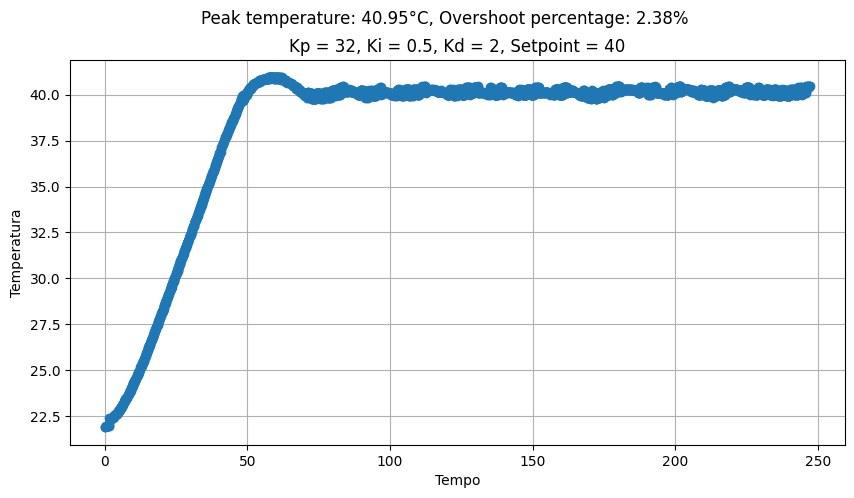

In [13]:
#32-0.5-2-40
#Diminuindo o Kd pra tentar diminuir o overshoot

file_path = '/Users/eduardosiqueirabonfim/Documents/Unicamp/Embarcados/ES670-2024-GrupoA2/jupyterNotebookForPlottingData/07-06 Data/32-0.5-2-40.csv'

# Le o arquivo e pula linhas irregulares
data = []
with open(file_path, 'r') as file:
    for line in file:
        if 't:' in line and 'T:' in line:
            parts = line.split(',')
            t_value = float(parts[0].split(':')[1].strip())
            T_value = float(parts[1].split(':')[1].strip())
            data.append((t_value, T_value))

# Converta a lista de tuplas em um DataFrame
df = pd.DataFrame(data, columns=['Time', 'Temperature'])

#Overshoot

# Achar a temperatura maxima
peak_temperature = df['Temperature'].max()

# Setpoint
steady_state_temp = 40

# Calculate the overshoot percentage
if steady_state_temp != 0:  # Avoid division by zero
    overshoot_percentage = ((peak_temperature - steady_state_temp) / steady_state_temp) * 100
else:
    overshoot_percentage = float('nan')  # Set overshoot to NaN if steady-state is zero
    
# Plotting Time versus Temperature 
plt.figure(figsize=(10, 5))
plt.plot(df['Time'], df['Temperature'], marker='o', linestyle='-', linewidth=0.5)
plt.xlabel('Tempo')
plt.ylabel('Temperatura')
plt.title('Kp = 32, Ki = 0.5, Kd = 2, Setpoint = 40')
plt.suptitle(f"Peak temperature: {peak_temperature}°C, " f"Overshoot percentage: {overshoot_percentage:.2f}%")
plt.grid(True)
plt.show()

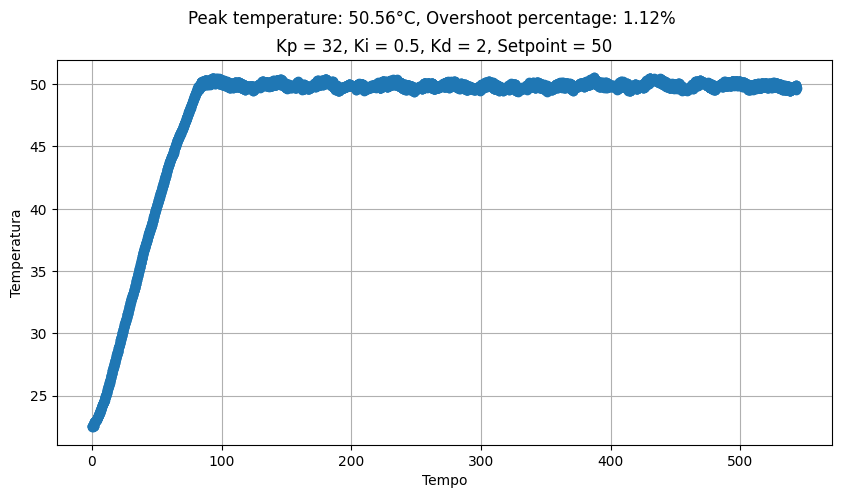

In [14]:
file_path = '/Users/eduardosiqueirabonfim/Documents/Unicamp/Embarcados/ES670-2024-GrupoA2/jupyterNotebookForPlottingData/07-06 Data/32-0.5-2-50.csv'

# Le o arquivo e pula linhas irregulares
data = []
with open(file_path, 'r') as file:
    for line in file:
        if 't:' in line and 'T:' in line:
            parts = line.split(',')
            t_value = float(parts[0].split(':')[1].strip())
            T_value = float(parts[1].split(':')[1].strip())
            data.append((t_value, T_value))

# Converta a lista de tuplas em um DataFrame
df = pd.DataFrame(data, columns=['Time', 'Temperature'])

#Overshoot

# Achar a temperatura maxima
peak_temperature = df['Temperature'].max()

# Setpoint
steady_state_temp = 50

# Calculate the overshoot percentage
if steady_state_temp != 0:  # Avoid division by zero
    overshoot_percentage = ((peak_temperature - steady_state_temp) / steady_state_temp) * 100
else:
    overshoot_percentage = float('nan')  # Set overshoot to NaN if steady-state is zero
    
# Plotting Time versus Temperature 
plt.figure(figsize=(10, 5))
plt.plot(df['Time'], df['Temperature'], marker='o', linestyle='-', linewidth=0.5)
plt.xlabel('Tempo')
plt.ylabel('Temperatura')
plt.title('Kp = 32, Ki = 0.5, Kd = 2, Setpoint = 50')
plt.suptitle(f"Peak temperature: {peak_temperature}°C, " f"Overshoot percentage: {overshoot_percentage:.2f}%")
plt.grid(True)
plt.show()

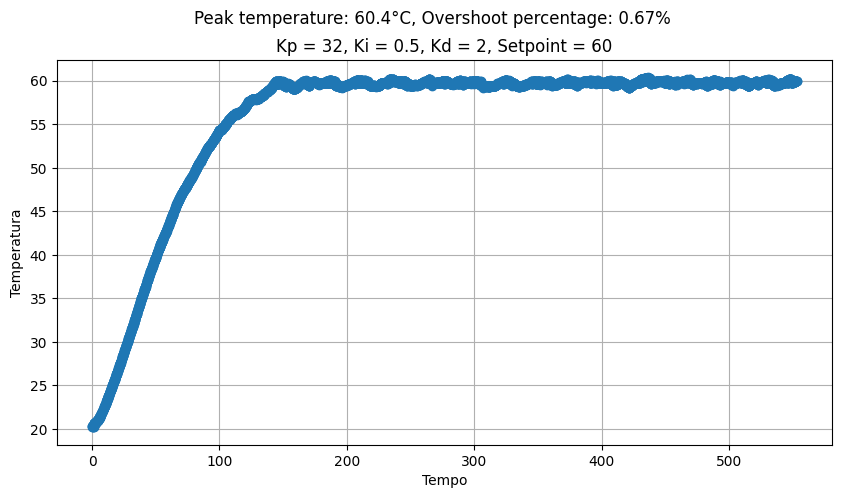

In [15]:
file_path = '/Users/eduardosiqueirabonfim/Documents/Unicamp/Embarcados/ES670-2024-GrupoA2/jupyterNotebookForPlottingData/07-06 Data/32-0.5-2-60.csv'

# Le o arquivo e pula linhas irregulares
data = []
with open(file_path, 'r') as file:
    for line in file:
        if 't:' in line and 'T:' in line:
            parts = line.split(',')
            t_value = float(parts[0].split(':')[1].strip())
            T_value = float(parts[1].split(':')[1].strip())
            data.append((t_value, T_value))

# Converta a lista de tuplas em um DataFrame
df = pd.DataFrame(data, columns=['Time', 'Temperature'])

#Overshoot

# Achar a temperatura maxima
peak_temperature = df['Temperature'].max()

# Setpoint
steady_state_temp = 60

# Calculate the overshoot percentage
if steady_state_temp != 0:  # Avoid division by zero
    overshoot_percentage = ((peak_temperature - steady_state_temp) / steady_state_temp) * 100
else:
    overshoot_percentage = float('nan')  # Set overshoot to NaN if steady-state is zero
    
# Plotting Time versus Temperature 
plt.figure(figsize=(10, 5))
plt.plot(df['Time'], df['Temperature'], marker='o', linestyle='-', linewidth=0.5)
plt.xlabel('Tempo')
plt.ylabel('Temperatura')
plt.title('Kp = 32, Ki = 0.5, Kd = 2, Setpoint = 60')
plt.suptitle(f"Peak temperature: {peak_temperature}°C, " f"Overshoot percentage: {overshoot_percentage:.2f}%")
plt.grid(True)
plt.show()